In [2]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

# Preview Dataset

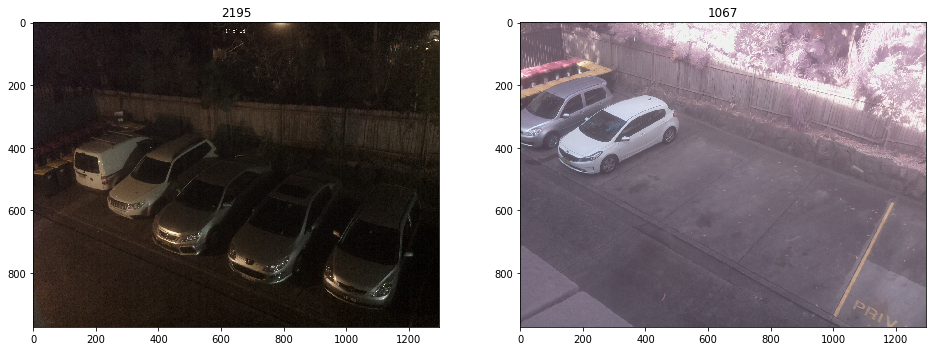

In [3]:
BASE_PATH = 'data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

# DataGenerator

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Free': 1, 'Full': 0}


# Load Model for Transfer Learning

In [5]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

# Switch Layers to be Trainable

In [6]:
for layer in model.layers:
    layer.trainable = True

# Train

In [7]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/10
92/92 [==============================] - 248s 3s/step - loss: 0.1447 - acc: 0.9548 - val_loss: 0.8897 - val_acc: 0.8092

Epoch 00001: val_acc improved from -inf to 0.80923, saving model to model.h5
Epoch 2/10
92/92 [==============================] - 183s 2s/step - loss: 0.0455 - acc: 0.9857 - val_loss: 0.2869 - val_acc: 0.9662

Epoch 00002: val_acc improved from 0.80923 to 0.96615, saving model to model.h5
Epoch 3/10
92/92 [==============================] - 145s 2s/step - loss: 0.0206 - acc: 0.9942 - val_loss: 0.4559 - val_acc: 0.9354

Epoch 00003: val_acc did not improve from 0.96615
Epoch 4/10
92/92 [==============================] - 145s 2s/step - loss: 0.0193 - acc: 0.9952 - val_loss: 0.2241 - val_acc: 0.9662

Epoch 00004: val_acc did not improve from 0.96615
Epoch 5/10
92/92 [==============================] - 146s 2s/step - loss: 0.0104 - acc: 0.9976 - val_loss: 0.2882 - val_acc: 0.9662

Epoch 00005: val_acc did not improve from 0.96615
Epoch 6/10
92/92 [===============

# Create New Model

In [28]:
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2)
   
new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

# Normal Prediction

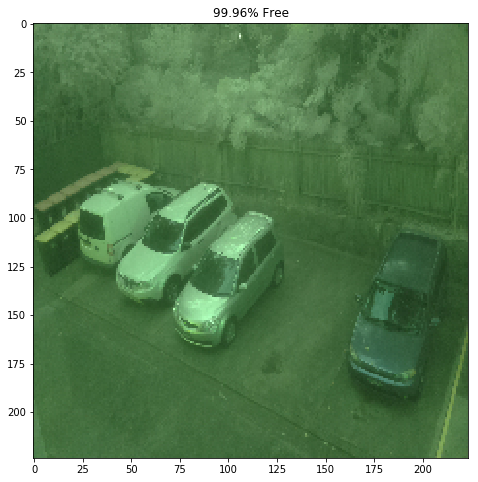

In [58]:
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

# Draw Activation Map

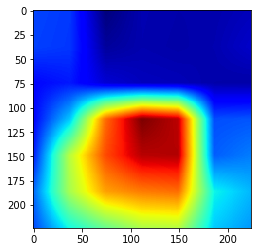

In [59]:
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

# Result

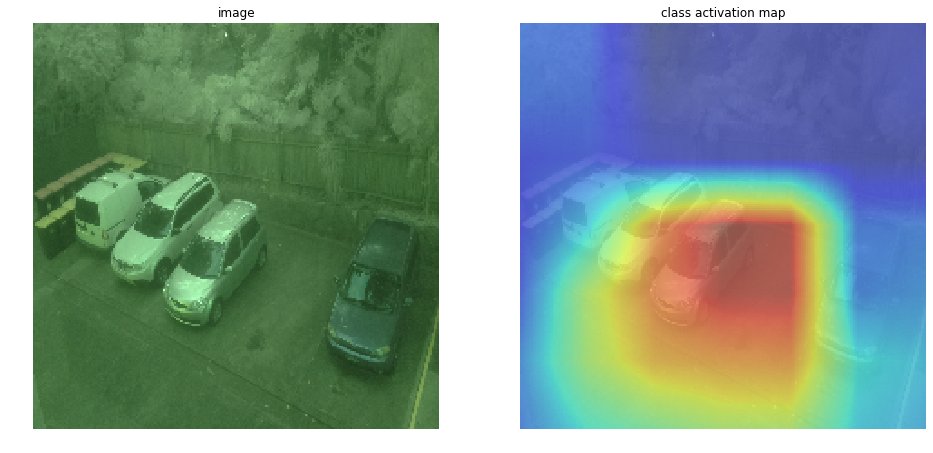

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()